In [86]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

from pandas import HDFStore,DataFrame
from pandas import read_hdf

import gc
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import f1_score

# 1. READ ENTIRE CSV FILE

In [87]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('data/train.csv')
    # print(traincsv[traincsv.isna().any()])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(g)

DiGraph with 1000 nodes and 100305 edges


### 1.1 Plot first 50 edges

DiGraph with 51 nodes and 50 edges


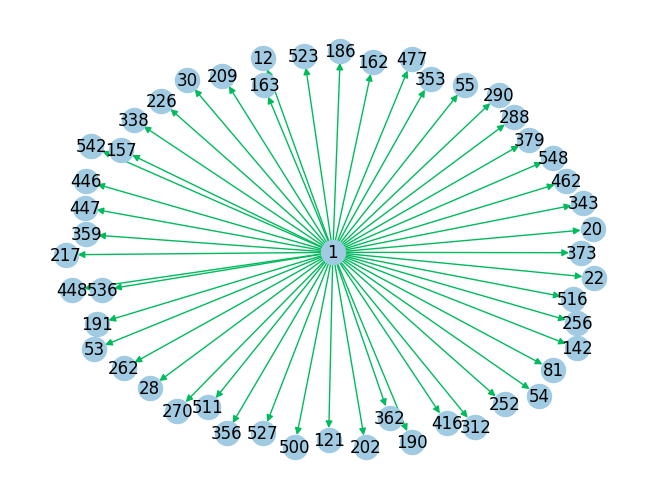

In [88]:
if not os.path.isfile('data/after_eda/train_woheader_sample.csv'):
    pd.read_csv('data/train.csv', nrows=50).to_csv('data/after_eda/train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('data/after_eda/train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(subgraph)

### 1.2 Graph summary

In [89]:
indegree_dist = list(dict(g.in_degree()).values())
outdegree_dist = list(dict(g.out_degree()).values())

In [90]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 0 and % is 0.0


In [91]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 0 and % is 0.0


In [92]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


# 2. CREATE TRAINING AND TESTING DATA

### 2.1 Create negative edges and save to pickle file  

In [93]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    for a in range(1,1001):
        for b in range(1,1001):
            if len(missing_edges)>100305:
                break
            tmp = edges.get((a,b),-1)
            if tmp == -1 and a!=b:
                try:
                    if nx.shortest_path_length(g,source=a,target=b) >= 2: 
                        missing_edges.add((a,b))
                    else:
                        continue  
                except:  
                        missing_edges.add((a,b))              
            else:
                continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

CPU times: total: 46.9 ms
Wall time: 127 ms


### 2.2 Create train and test for negative and positive edges and save to csv file

In [94]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

### 2.3 Combine them train_pos and train_neg,test_pos and test_neg together and save to csv file

In [95]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = pd.concat([X_train_pos,X_train_neg],ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = pd.concat([X_test_pos,X_test_neg],ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

    print("Data points in train data", X_train.shape)
    print("Data points in test data", X_test.shape)
    print("Shape of traget variable in train", y_train.shape)
    print("Shape of traget variable in test", y_test.shape)

# 3. Feature extraction

In [96]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(train_graph)
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1000 nodes and 80244 edges


### 3.1 Feature for 2 nodes

#### + Jacaard Distance

In [97]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [98]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### + Cosine Distance

In [99]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [100]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### + Shortest path

In [101]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

#### + Check for the same community

In [102]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

#### + Adar Index

In [103]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

#### + Is follow back

In [104]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

### 3.2 Feature from graph

#### + Page Ranking

In [105]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)


min 0.0006736040452141739
max 0.001308513685904118
mean 0.0009999999999999998
0.0009999999999999998


#### + Katz Centrality

In [106]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

min 0.0267868510751356
max 0.036105888238737505
mean 0.03159463714469249
0.03159463714469249


#### + Hits Score

In [107]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0006160979170520014
max 0.0013472754616826283
mean 0.0009999999999999998


# 4. Featurization

### 4.1 Reading a sample of Data from both train and test

In [108]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  160488
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [109]:
if os.path.isfile('data/after_eda/test_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 40123
    s = 30000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [110]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 160488
Number of rows we are going to elimiate in train data are 60488
Number of rows in the test data file: 40123
Number of rows we are going to elimiate in test data are 10123


In [111]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,699,331,1
1,326,461,1


In [112]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (30000, 3)


,source_node,destination_node,indicator_link
0,501,896,1
1,138,302,1


### 4.2 Adding a set of features

#### +we will create these each of these features for both train and test data points

1.	jaccard_followers
2.	jaccard_followees
3.	cosine_followers
4.	cosine_followees
5.	num_followers_s
6.	num_followees_s
7.	num_followers_d
8.	num_followees_d
9.	inter_followers
10.	inter_followees


In [113]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    print("Inside if")
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

Inside if


In [114]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [115]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

#### +we will create these each of these features for both train and test data points

1. adar index
2. is following back
3. belongs to same weakly connect components
4. shortest path between source and destination

In [116]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

1.	Weight Features
    -	weight of incoming edges
    -	weight of outgoing edges
    -	weight of incoming edges + weight of outgoing edges
    -	weight of incoming edges * weight of outgoing edges
    -	2*weight of incoming edges + weight of outgoing edges
    -	weight of incoming edges + 2*weight of outgoing edges
2.	Page Ranking of source
3.	Page Ranking of dest
4.	katz of source
5.	katz of dest
6.	hubs of source
7.	hubs of dest
8.	authorities_s of source
9.	authorities_s of dest


In [117]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1000/1000 [00:00<00:00, 38472.09it/s]


In [118]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    print("File not present")
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [119]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

In [120]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,699,331,1,0.040230,0.044025,0.007874,0.084491,84,97,78,...,0.314539,0.326033,0.001044,0.001184,0.032303,0.034109,0.000997,0.001063,0.001061,0.001183
1,921,164,1,0.031008,0.046154,0.007404,0.088388,67,66,64,...,0.368374,0.370239,0.000858,0.000848,0.029492,0.029298,0.000793,0.000898,0.000835,0.000814
2,268,963,1,0.034483,0.019608,0.007600,0.038462,73,77,78,...,0.338964,0.338245,0.000918,0.000953,0.030395,0.030972,0.000956,0.000957,0.000904,0.000957
3,359,485,1,0.050847,0.054422,0.010397,0.103487,99,87,83,...,0.322310,0.324818,0.001202,0.001069,0.034479,0.032775,0.001028,0.000913,0.001219,0.001109
4,527,928,1,0.023952,0.029586,0.005137,0.057608,88,83,93,...,0.321360,0.315393,0.001092,0.001034,0.032875,0.032013,0.001168,0.001014,0.001095,0.001027


#### +we will create these each of these features for both train and test data points
1. SVD features for both source and destination

In [121]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
def svd(x, S):
    try:
        sadj_col = sorted(train_graph.nodes())
        sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [122]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [123]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [124]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1000, 1000)
U Shape (1000, 6)
V Shape (6, 1000)
s Shape (6,)


In [133]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

In [134]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'preferential_followers', 'preferential_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### 4.3 Preferential Attachment

#### +Preferential Attachement for followers

In [135]:
#for train dataset

train_followers_s = np.array(df_final_train['num_followers_s'])
train_followers_d = np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(train_followers_s)):
    preferential_followers.append(train_followers_d[i]*train_followers_s[i])
df_final_train['preferential_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,699,331,1,0.040230,0.044025,0.007874,0.084491,84,97,78,...,-0.017754,0.004886,-0.006905,0.033370,-0.045540,0.031787,0.057822,0.041508,-0.021306,0.037200
1,921,164,1,0.031008,0.046154,0.007404,0.088388,67,66,64,...,-0.029505,-0.023654,-0.018997,0.026247,0.033027,0.007777,0.012791,-0.003428,-0.010191,0.025585
2,268,963,1,0.034483,0.019608,0.007600,0.038462,73,77,78,...,0.032172,0.008269,-0.008797,0.028443,-0.043343,0.006653,-0.056616,0.021909,0.021785,0.030099
3,359,485,1,0.050847,0.054422,0.010397,0.103487,99,87,83,...,-0.005177,0.019223,0.009567,0.038335,0.000030,-0.037869,-0.011870,-0.026244,-0.010608,0.034861
4,527,928,1,0.023952,0.029586,0.005137,0.057608,88,83,93,...,-0.017498,0.073759,-0.053323,0.034429,-0.022326,0.017121,0.029989,-0.014577,0.079870,0.032307


In [136]:
# for test dataset

test_followers_s = np.array(df_final_test['num_followers_s'])
test_followers_d = np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(test_followers_s)):
    preferential_followers.append(test_followers_d[i]*test_followers_s[i])
df_final_test['preferential_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,501,896,1,0.043796,0.042857,0.009592,0.082471,66,77,67,...,0.017308,0.005356,-0.021593,0.025883,-0.005139,0.012700,0.053530,-0.007163,0.009072,0.030228
1,642,546,1,0.052632,0.056604,0.011612,0.109141,104,76,100,...,-0.030399,0.005268,0.013833,0.040917,-0.056326,-0.013424,-0.038176,-0.000748,-0.010174,0.029849
2,875,526,1,0.032895,0.032258,0.007003,0.062994,74,83,70,...,0.021605,0.019959,-0.003107,0.028566,-0.035734,-0.038920,0.056374,-0.010137,0.006327,0.032409
3,734,943,1,0.060811,0.068182,0.013068,0.127663,80,77,71,...,0.012463,0.042751,0.008569,0.030571,0.042248,0.024579,0.007941,-0.032606,0.036786,0.030556
4,926,989,1,0.032468,0.031056,0.007274,0.060280,84,75,80,...,-0.018851,0.013228,0.015679,0.032849,-0.015442,-0.029019,-0.036819,0.014286,0.030106,0.029723


#### + Preferential Attachement for followees

In [137]:
#for train dataset

train_followees_s = np.array(df_final_train['num_followees_s'])
train_followees_d = np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(train_followees_s)):
    preferential_followees.append(train_followees_d[i]*train_followees_s[i])
df_final_train['preferential_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,699,331,1,0.040230,0.044025,0.007874,0.084491,84,97,78,...,-0.017754,0.004886,-0.006905,0.033370,-0.045540,0.031787,0.057822,0.041508,-0.021306,0.037200
1,921,164,1,0.031008,0.046154,0.007404,0.088388,67,66,64,...,-0.029505,-0.023654,-0.018997,0.026247,0.033027,0.007777,0.012791,-0.003428,-0.010191,0.025585
2,268,963,1,0.034483,0.019608,0.007600,0.038462,73,77,78,...,0.032172,0.008269,-0.008797,0.028443,-0.043343,0.006653,-0.056616,0.021909,0.021785,0.030099
3,359,485,1,0.050847,0.054422,0.010397,0.103487,99,87,83,...,-0.005177,0.019223,0.009567,0.038335,0.000030,-0.037869,-0.011870,-0.026244,-0.010608,0.034861
4,527,928,1,0.023952,0.029586,0.005137,0.057608,88,83,93,...,-0.017498,0.073759,-0.053323,0.034429,-0.022326,0.017121,0.029989,-0.014577,0.079870,0.032307


In [138]:
#for test dataset

test_followees_s = np.array(df_final_test['num_followees_s'])
test_followees_d = np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(test_followees_s)):
    preferential_followees.append(test_followees_d[i]*test_followees_s[i])
df_final_test['preferential_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,501,896,1,0.043796,0.042857,0.009592,0.082471,66,77,67,...,0.017308,0.005356,-0.021593,0.025883,-0.005139,0.012700,0.053530,-0.007163,0.009072,0.030228
1,642,546,1,0.052632,0.056604,0.011612,0.109141,104,76,100,...,-0.030399,0.005268,0.013833,0.040917,-0.056326,-0.013424,-0.038176,-0.000748,-0.010174,0.029849
2,875,526,1,0.032895,0.032258,0.007003,0.062994,74,83,70,...,0.021605,0.019959,-0.003107,0.028566,-0.035734,-0.038920,0.056374,-0.010137,0.006327,0.032409
3,734,943,1,0.060811,0.068182,0.013068,0.127663,80,77,71,...,0.012463,0.042751,0.008569,0.030571,0.042248,0.024579,0.007941,-0.032606,0.036786,0.030556
4,926,989,1,0.032468,0.031056,0.007274,0.060280,84,75,80,...,-0.018851,0.013228,0.015679,0.032849,-0.015442,-0.029019,-0.036819,0.014286,0.030106,0.029723


### 4.4 SVD_dot

In [139]:
#for train datasets
su1,su2,su3,su4,su5,su6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [140]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

(1077, 6)
(1077, 6)


In [141]:
du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(1077, 6)
(1077, 6)


In [142]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_train['ud_dot']=u_dot
df_final_train['vd_dot']=v_dot

In [143]:
#for test datasets
su1,su2,su3,su4,su5,su6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [144]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(506, 6)
(506, 6)
(506, 6)
(506, 6)


In [145]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_test['ud_dot']=u_dot
df_final_test['vd_dot']=v_dot

In [146]:
hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

# 5. Models

In [175]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [176]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'preferential_followers', 'preferential_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [177]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'preferential_followers', 'preferential_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [178]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [179]:
train_nodes = df_final_train.loc[:,["source_node","destination_node"]]
test_nodes = df_final_test.loc[:,["source_node","destination_node"]]

In [180]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [181]:
train_nodes.head()

,source_node,destination_node
0,699,331
1,921,164
2,268,963
3,359,485
4,527,928


### 5.1 Random Forest

Estimators =  10 Train Score 0.8862973760932945 Test Score 0.8602540834845736
Estimators =  50 Train Score 0.8944099378881988 Test Score 0.9039548022598869
Estimators =  100 Train Score 0.8886576482830385 Test Score 0.8994307400379508
Estimators =  250 Train Score 0.8863399374348279 Test Score 0.8994307400379508
Estimators =  450 Train Score 0.8875 Test Score 0.8994307400379508


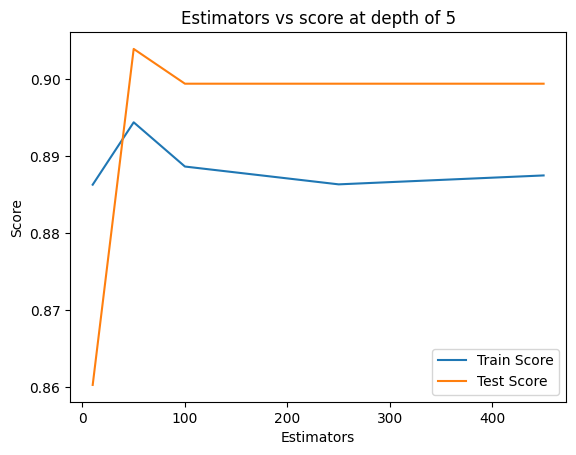

In [182]:
estimators = [10, 50, 100, 250, 450]
train_scores = []
test_scores = []

for i in estimators:
    clf = RandomForestClassifier(
        bootstrap=True, class_weight=None, criterion='gini',
        max_depth=5, max_features='sqrt', 
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=52, min_samples_split=120,
        min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,
        random_state=25, verbose=0, warm_start=False
    )
    clf.fit(df_final_train, y_train)
    train_sc = f1_score(y_train, clf.predict(df_final_train))
    test_sc = f1_score(y_test, clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ', i, 'Train Score', train_sc, 'Test Score', test_sc)

plt.plot(estimators, train_scores, label='Train Score')
plt.plot(estimators, test_scores, label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
plt.legend()
plt.show()


depth =  3 Train Score 0.8902691511387163 Test Score 0.9015151515151515
depth =  9 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  11 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  15 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  20 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  35 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  50 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  70 Train Score 0.8909657320872273 Test Score 0.8998109640831758
depth =  130 Train Score 0.8909657320872273 Test Score 0.8998109640831758


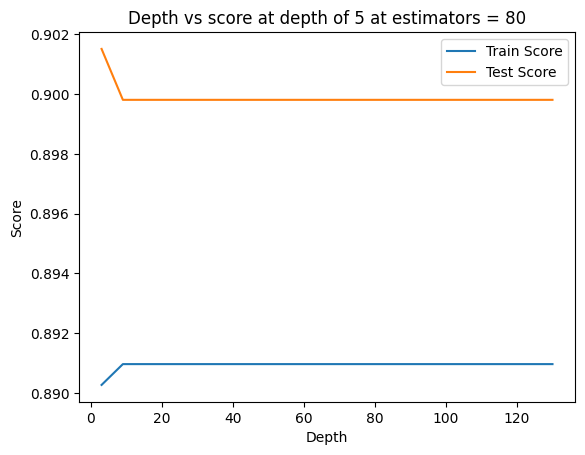

In [183]:
depths = [3, 9, 11, 15, 20, 35, 50, 70, 130]
train_scores = []
test_scores = []

for i in depths:
    clf = RandomForestClassifier(
        bootstrap=True, class_weight=None, criterion='gini',
        max_depth=i, max_features='sqrt', max_leaf_nodes=None,
        min_impurity_decrease=0.0,  
        min_samples_leaf=52, min_samples_split=120,
        min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
        random_state=25, verbose=0, warm_start=False
    )
    clf.fit(df_final_train, y_train)
    train_sc = f1_score(y_train, clf.predict(df_final_train))
    test_sc = f1_score(y_test, clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ', i, 'Train Score', train_sc, 'Test Score', test_sc)

plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 80')
plt.legend()
plt.show()


In [184]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {
    "n_estimators": sp_randint(50, 100),
    "max_depth": sp_randint(10, 20),
    "min_samples_split": sp_randint(110, 190),
    "min_samples_leaf": sp_randint(25, 65)
}

clf = RandomForestClassifier(random_state=25, n_jobs=-1)

rf_random = RandomizedSearchCV(
    clf, param_distributions=param_dist,
    n_iter=5, cv=10, scoring='f1', random_state=25
)

rf_random.fit(df_final_train, y_train)
print('mean test scores', rf_random.cv_results_['mean_test_score'])
print('mean fit times', rf_random.cv_results_['mean_fit_time'])

mean test scores [0.88593153 0.88702409 0.88737346 0.88436085 0.8851839 ]
mean fit times [0.37353892 0.29559295 0.27140112 0.28698292 0.36816711]


In [185]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=19, min_samples_leaf=56, min_samples_split=179,
                       n_estimators=51, n_jobs=-1, random_state=25)


In [186]:
clf = RandomForestClassifier(
    bootstrap=True, class_weight=None, criterion='gini',
    max_depth=19, max_features='sqrt', max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_samples_leaf=56, min_samples_split=179,
    min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
    oob_score=False, random_state=25, verbose=0, warm_start=False
)


In [187]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [188]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.8923395445134575
Test f1 score 0.9001883239171375


In [189]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


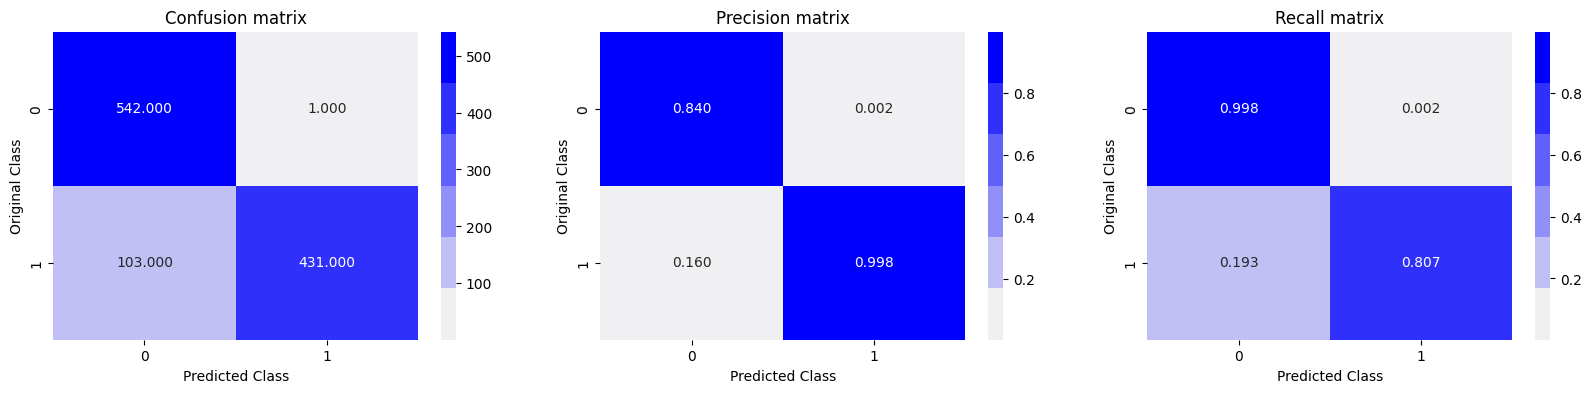

Test confusion_matrix


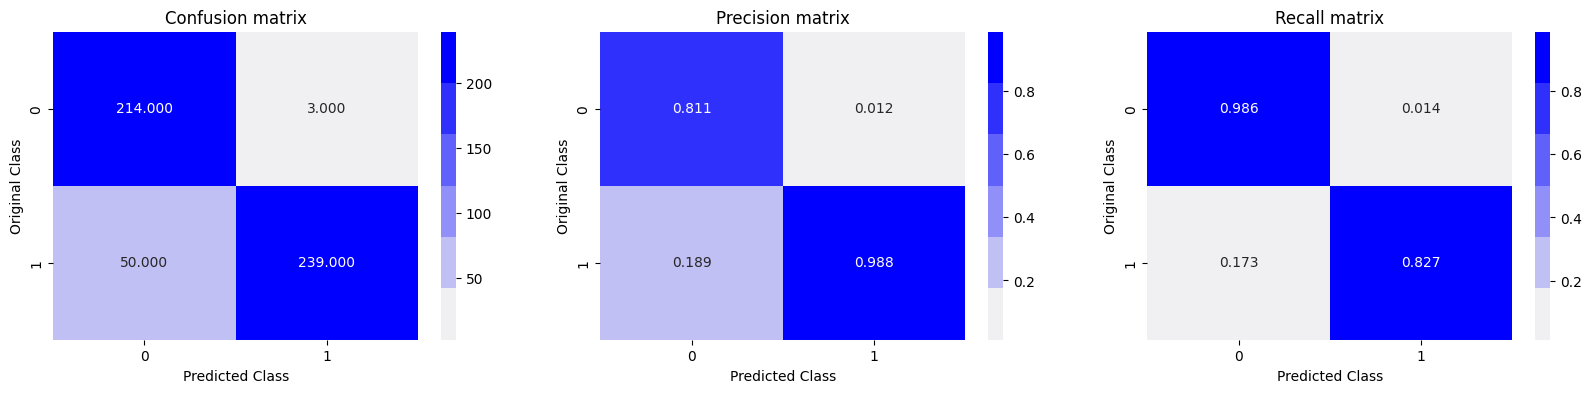

In [190]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

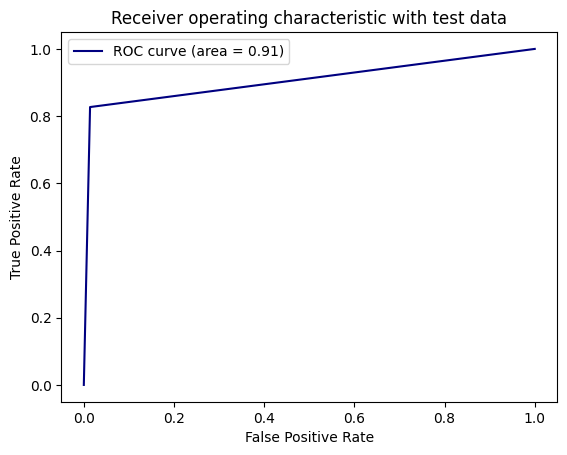

In [191]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

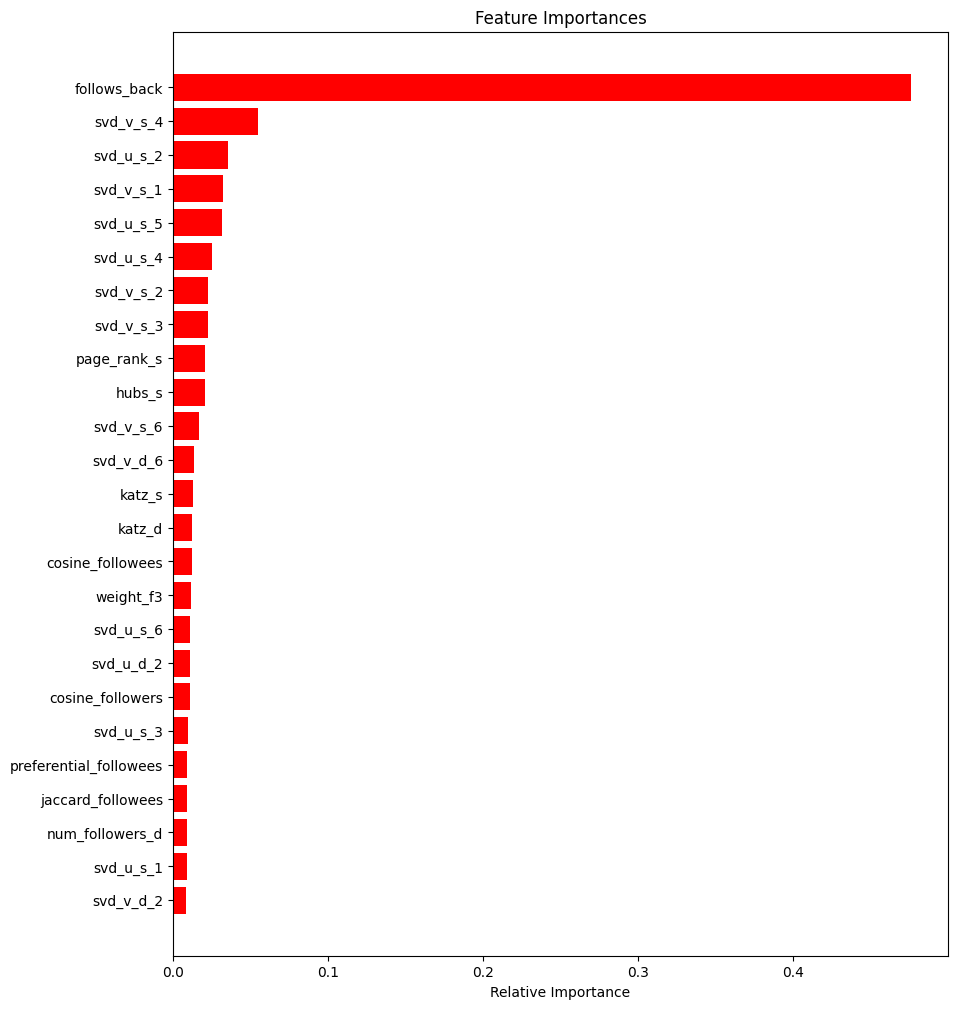

In [192]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [212]:
import random
import numpy as np
idx = random.randint(0,505)
pred = clf.predict(np.array(df_final_test.iloc[idx]).reshape(1,-1))
source_node = test_nodes.iloc[idx].values[0]
des_node = test_nodes.iloc[idx].values[1]
if pred == 1:
    print(f"node {source_node} and node {des_node} is friend!!!")
else:
    print(f"node {source_node} and node {des_node} is not friend!!!")

node 7 and node 150 is not friend!!!


### 5.2 XGBOOST (Tuning)

In [214]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(50,100),
              "max_depth": sp_randint(10,20)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_fit_time'])

mean test scores [0.8841014  0.88999058 0.88683321 0.8852608  0.87964584]
mean train scores [1.36240943 0.27972881 0.17432976 0.19266907 0.19763327]


In [215]:
print(model.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=73, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [216]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=-999, n_estimators=76,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [217]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [218]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9077212806026366


Train confusion_matrix


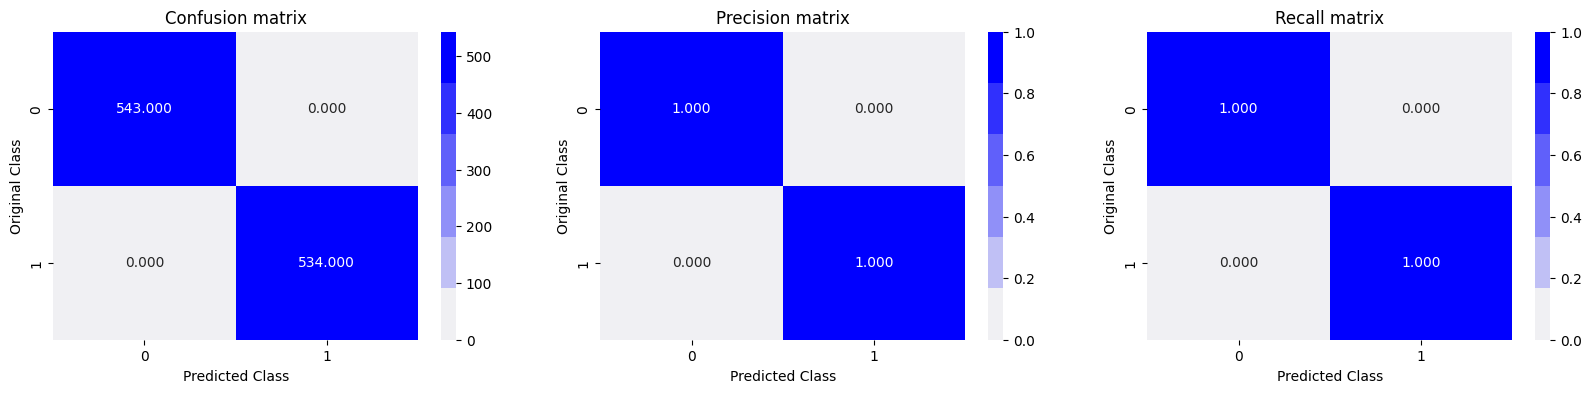

Test confusion_matrix


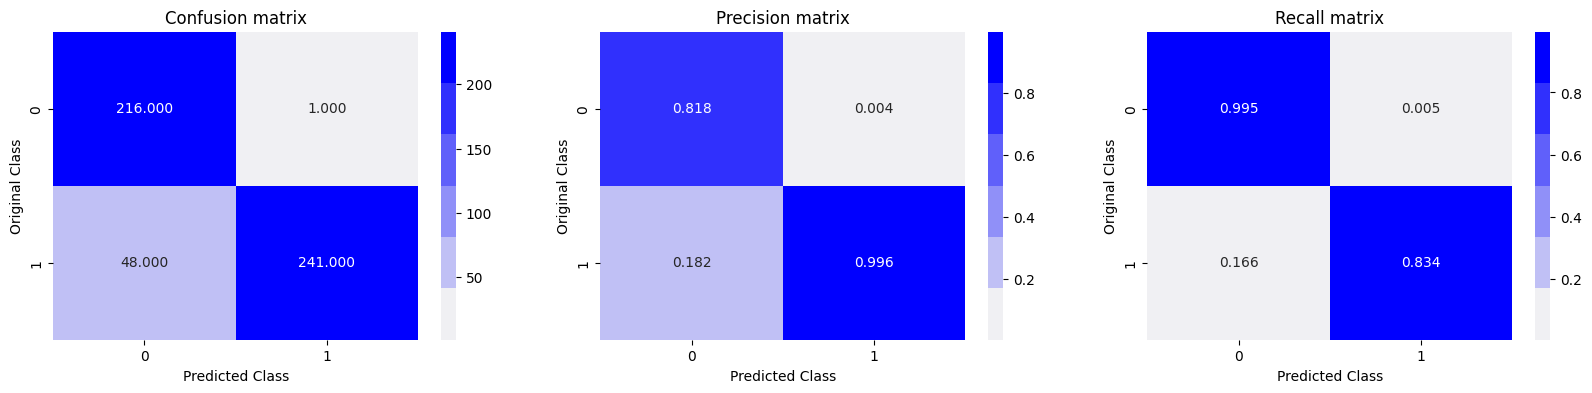

In [219]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

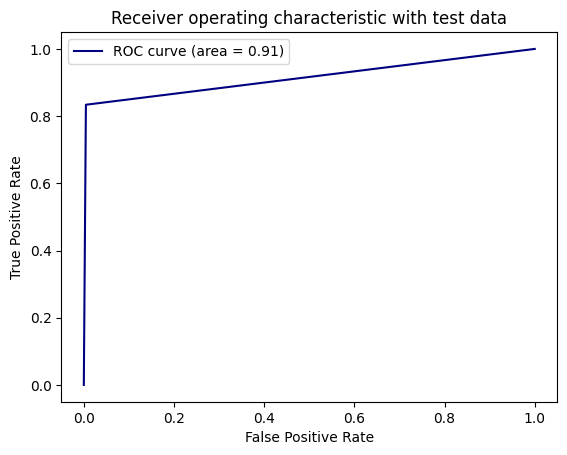

In [220]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

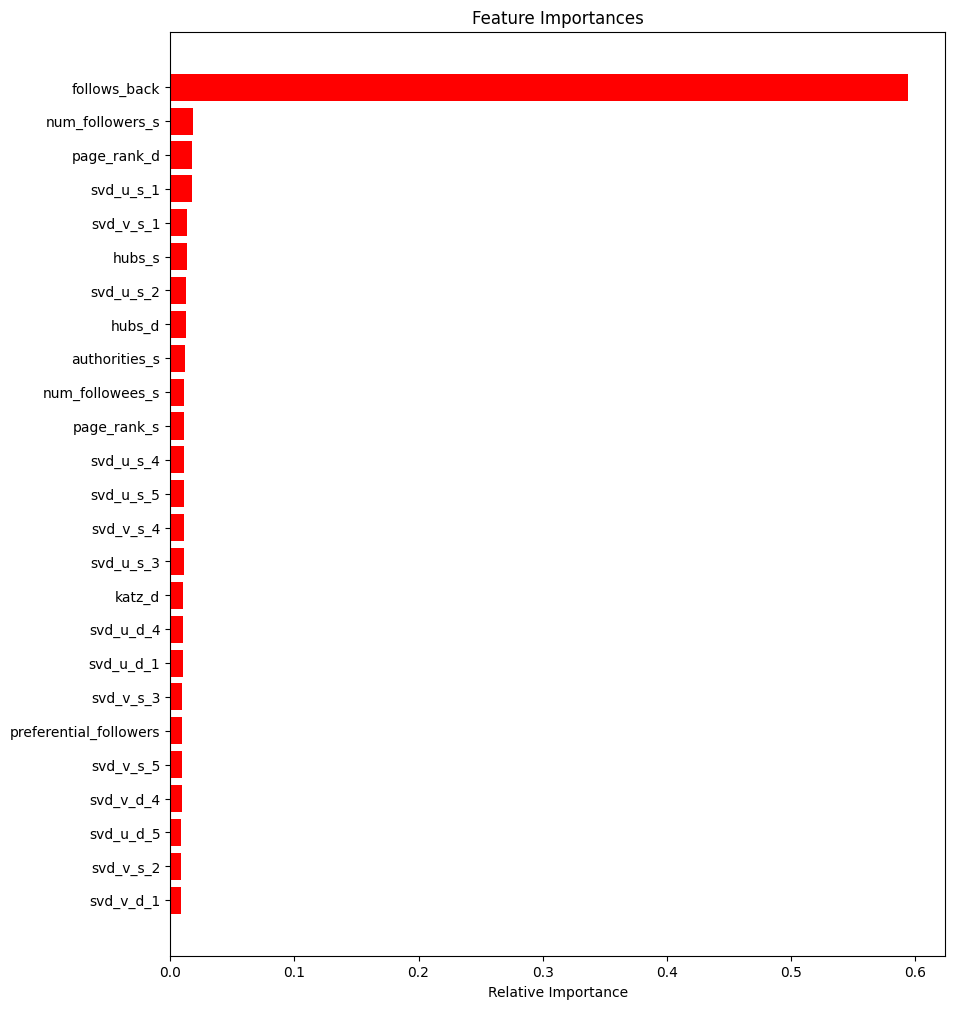

In [221]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [222]:
import random
import numpy as np
idx = random.randint(0,505)
pred = clf.predict(np.array(df_final_test.iloc[idx]).reshape(1,-1))
source_node = test_nodes.iloc[idx].values[0]
des_node = test_nodes.iloc[idx].values[1]
if pred == 1:
    print(f"node {source_node} and node {des_node} is friend!!!")
else:
    print(f"node {source_node} and node {des_node} is not friend!!!")

node 132 and node 920 is friend!!!
